<a href="https://colab.research.google.com/github/GOUTAM-RAM21/data-science-ml/blob/main/Plant_village_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


In [4]:
import zipfile
import os

zip_path = "/content/PlantVillage.zip"
extract_path = "/content/PlantVillage"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("PlantVillage dataset extracted successfully!")


PlantVillage dataset extracted successfully!


In [5]:
!ls /content/PlantVillage


__MACOSX  PlantVillage


Found 33027 images belonging to 16 classes.
Found 8249 images belonging to 16 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1033/1033 ━━━━━━━━━━━━━━━━━━━━ 1128s 1s/step - accuracy: 0.4916 - loss: 1.8320 - val_accuracy: 0.2731 - val_loss: 1.6069


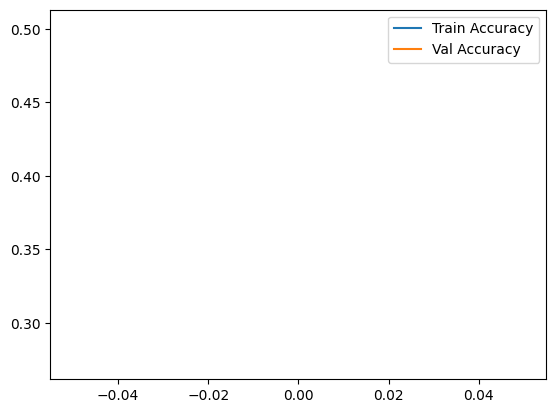

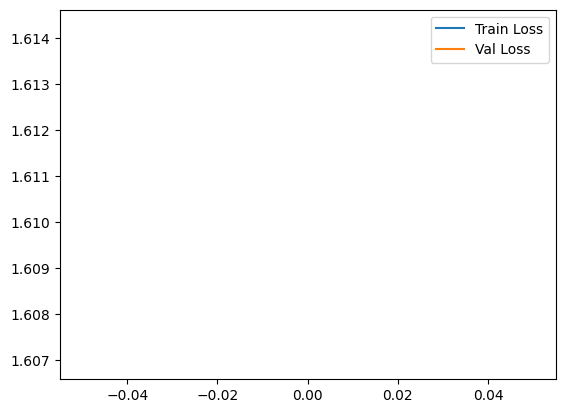

/tmp/ipython-input-31245414.py:146: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()
/tmp/ipython-input-31245414.py:146: DeprecationWarning: The default value of 'allow_tags' in gr.Chatbot will be changed from False to True in Gradio 6.0. You will need to explicitly set allow_tags=False if you want to disable tags in your chatbot.
  chatbot = gr.Chatbot()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://41163ec920a16e036e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [7]:

train_dir = "/content/PlantVillage/PlantVillage"


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
import gradio as gr

img_size = 128
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1
)


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()


treatment_dict = {
    "Tomato_Septoria_leaf_spot": "Spray Mancozeb or Chlorothalonil. Avoid overhead irrigation.",
    "Pepper__bell___Bacterial_spot": "Apply copper-based bactericides and use resistant seeds.",
    "Tomato_healthy": "Plant is healthy. Maintain proper care.",
    "Pepper__bell___healthy": "Healthy crop. Continue good practices."
}

last_prediction = {"disease": None, "treatment": None}


def predict_image(img):
    img = img.resize((128, 128))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    class_idx = np.argmax(pred)
    class_name = list(train_generator.class_indices.keys())[class_idx]

    treatment = treatment_dict.get(class_name, "No treatment info available.")
    last_prediction["disease"] = class_name
    last_prediction["treatment"] = treatment

    return {class_name: float(pred[0][class_idx])}, treatment


def chatbot_response(history, user_input):
    if last_prediction["disease"] is None:
        bot_reply = "Please upload a crop leaf image first."
    else:
        if "treatment" in user_input.lower():
            bot_reply = last_prediction["treatment"]
        elif "disease" in user_input.lower():
            bot_reply = last_prediction["disease"]
        else:
            bot_reply = "Ask about disease name or treatment."

    history.append((user_input, bot_reply))
    return history, ""


with gr.Blocks() as demo:
    with gr.Row():
        image_input = gr.Image(type="pil", label="Upload Leaf Image")
        disease_label = gr.Label(label="Predicted Disease")
        treatment_box = gr.Textbox(label="Treatment", lines=4)

    chatbot = gr.Chatbot()
    msg = gr.Textbox()
    msg.submit(chatbot_response, [chatbot, msg], [chatbot, msg])

    image_input.upload(predict_image, image_input, [disease_label, treatment_box])

demo.launch()